## Eye Pattern Recognition

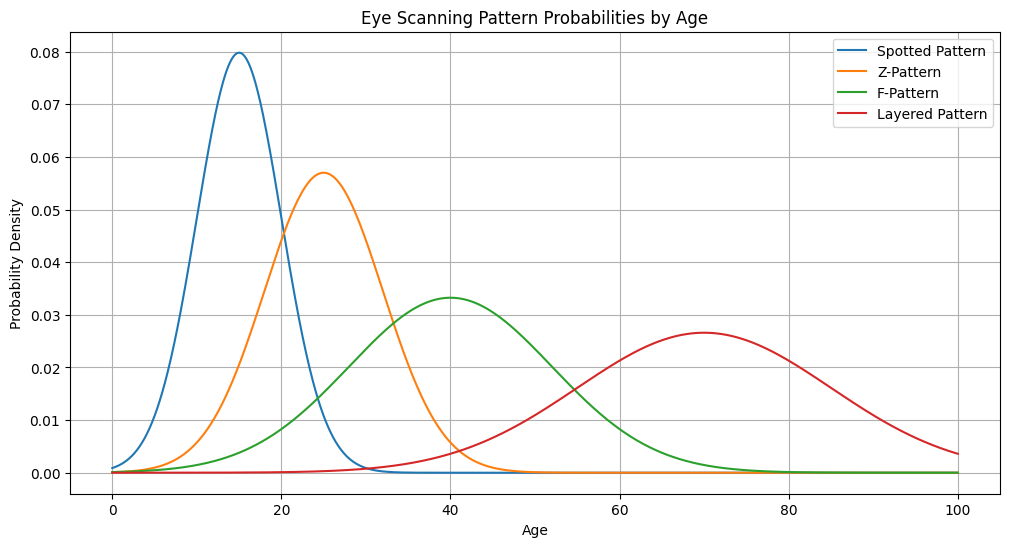


Quick predictions:
Age 15: Spotted Pattern
Age 22: Z-Pattern
Age 35: F-Pattern
Age 65: Layered Pattern
Age 75: Layered Pattern


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

class EyePatternPredictor:
    def __init__(self):
        # Define patterns with their normal distributions (mean, std)
        self.patterns = {
            'spotted': norm(15, 5),   # Teenagers - scattered, non-linear exploration pattern
            'z_pattern': norm(25, 7),  # Young adults - quick zigzag assessment pattern
            'f_pattern': norm(40, 12), # Middle-aged - horizontal top + vertical left scanning
            'layered': norm(70, 15)    # Elderly - methodical, layer-by-layer reading
        }
        
        self.pattern_names = {
            'spotted': 'Spotted Pattern',
            'z_pattern': 'Z-Pattern',
            'f_pattern': 'F-Pattern',
            'layered': 'Layered Pattern'
        }

    def predict(self, age):
        """Predicts single most likely eye scanning pattern for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # small interval (epsilon) around the point
        epsilon = 0.1
        
        probabilities = {
            pattern: dist.cdf(age + epsilon/2) - dist.cdf(age - epsilon/2)
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities to sum to 1
        total = sum(probabilities.values())
        normalized_probs = {
            k: v/total for k, v in probabilities.items()
        }
        
        # Select pattern with highest probability
        selected_pattern = max(normalized_probs, key=normalized_probs.get)
        return self.pattern_names[selected_pattern]

    def explain_prediction(self, age):
        """Shows detailed probability breakdown for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # Get raw probabilities
        raw_probs = {
            pattern: dist.pdf(age) 
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities
        total = sum(raw_probs.values())
        normalized = {k: v/total for k, v in raw_probs.items()}
        
        print(f"\nProbability breakdown for age {age}:")
        print("\nRaw probabilities (from PDF):")
        for pattern, prob in raw_probs.items():
            print(f"{self.pattern_names[pattern]}: {prob:.4f}")
            
        print("\nNormalized probabilities:")
        for pattern, prob in normalized.items():
            print(f"{self.pattern_names[pattern]}: {prob:.2%}")
            
        winner = max(normalized, key=normalized.get)
        print(f"\nPredicted pattern: {self.pattern_names[winner]}")

    def visualize_distributions(self):
        """Visualizes the probability distributions for all patterns."""
        ages = np.linspace(0, 100, 1000)
        
        plt.figure(figsize=(12, 6))
        
        # Plot each distribution
        for pattern, dist in self.patterns.items():
            probabilities = dist.pdf(ages)
            plt.plot(ages, probabilities, label=self.pattern_names[pattern])
        
        # Plot styling
        plt.title('Eye Scanning Pattern Probabilities by Age')
        plt.xlabel('Age')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        plt.show()


# Create predictor
predictor = EyePatternPredictor()

# Show distributions
predictor.visualize_distributions()

# Test some predictions
test_ages = [15, 22, 35, 65, 75]
print("\nQuick predictions:")
for age in test_ages:
    pattern = predictor.predict(age)
    print(f"Age {age}: {pattern}")

In [2]:
# Detailed explanation for one age
predictor.explain_prediction(35)


Probability breakdown for age 35:

Raw probabilities (from PDF):
Spotted Pattern: 0.0000
Z-Pattern: 0.0205
F-Pattern: 0.0305
Layered Pattern: 0.0017

Normalized probabilities:
Spotted Pattern: 0.05%
Z-Pattern: 38.91%
F-Pattern: 57.73%
Layered Pattern: 3.31%

Predicted pattern: F-Pattern
